<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_Attention_Mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def sequence_mask(X,valid_len,fill_value=0):
  """Mask irrelevant entries in sequences."""
  #batch_size X num_steps
  maxlen=X.size(1)
  #Here torch.arange((maxlen)) becomes 1 X num_steps and valid_len becomes batch_size X 1
  #Comparing both after broadcasting we get batch_size X num_steps
  mask=torch.arange((maxlen),dtype=torch.float32,device=X.device)[None, :] < valid_len[:, None]
  X[~mask] = fill_value 
  return X 
 

In [4]:
def masked_softmax(X,valid_lens):
  """Perform softmax operation by masking elements on the last axis."""
  # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
  if valid_lens is None:
    return nn.functional.softmax(X, dim=-1)

  else:
    shape = X.shape
    if valid_lens.dim() == 1: #(batch_size,)
      valid_lens = torch.repeat_interleave(valid_lens, shape[1]) #batch_size X seq_len
    
    else:
      valid_lens = valid_lens.reshape(-1) #num_examples

    # On the last axis, replace masked elements with a very large negative value, whose exponentiation outputs 0
    X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,fill_value=-1e6)
    
    return nn.functional.softmax(X.reshape(shape), dim=-1)


In [5]:
masked_softmax(torch.rand(2, 3, 10), torch.tensor([2, 3]))

tensor([[[0.5189, 0.4811, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.3297, 0.6703, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.6325, 0.3675, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.2397, 0.2859, 0.4744, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.4144, 0.3892, 0.1964, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.3825, 0.3889, 0.2286, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]]])

In [6]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4684, 0.2853, 0.2462, 0.0000]],

        [[0.4626, 0.5374, 0.0000, 0.0000],
         [0.1904, 0.2882, 0.2386, 0.2828]]])

# Additive Attention

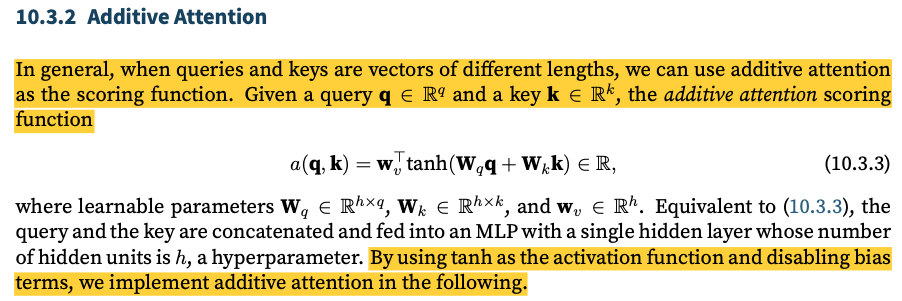

In [7]:
class AdditiveAttention(nn.Module):
  def __init__(self,query_size,key_size,hidden_dims,dropout,**kwargs):
    super(AdditiveAttention,self).__init__(**kwargs)
    self.W_q=nn.Linear(query_size,hidden_dims,bias=False)
    self.W_k=nn.Linear(key_size,hidden_dims,bias=False)
    self.W_v=nn.Linear(hidden_dims,1,bias=False)
    self.dropout = nn.Dropout(dropout)

  def forward(self,queries,keys,values,valid_lens):
    #q-> batch_size X no_of_queries X query_dims
    #k-> batch_size X no_of_keys X key_dims
    #v-> batch_size X no_of_values X value_dims

    queries=self.W_q(queries) #q-> batch_size X no_of_queries X hidden_dims
    keys=self.W_k(keys) #k-> batch_size X no_of_keys X hidden_dims
    features=queries[:,:,None,:]+keys[:,None,:,:]
    features = torch.tanh(features) #batch_size X no_of_queries X no_of_keys X hidden_dims
    scores = self.W_v(features).squeeze(-1) #batch_size X no_of_queries X no_of_keys X 1 (before squeezing)
    self.attention_weights = masked_softmax(scores, valid_lens) #batch_size X no_of_queries X no_of_keys
    
    #Note that no of keys is always equal to no of values
    #batch_size,no_of_queries,no_of_keys X batch_size,no_of_values,value_dims -> batch_size,no_of_queries,value_dims

    return torch.bmm(self.dropout(self.attention_weights), values) 



In [8]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))

# The two value matrices in the `values` minibatch are identical

values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(query_size=20,key_size=2, hidden_dims=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens) #batch_size X no_of_queries X value_dims

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

In [9]:
attention.attention_weights.shape

torch.Size([2, 1, 10])

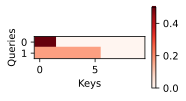

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries') #

# Scaled-Dot Product Attention

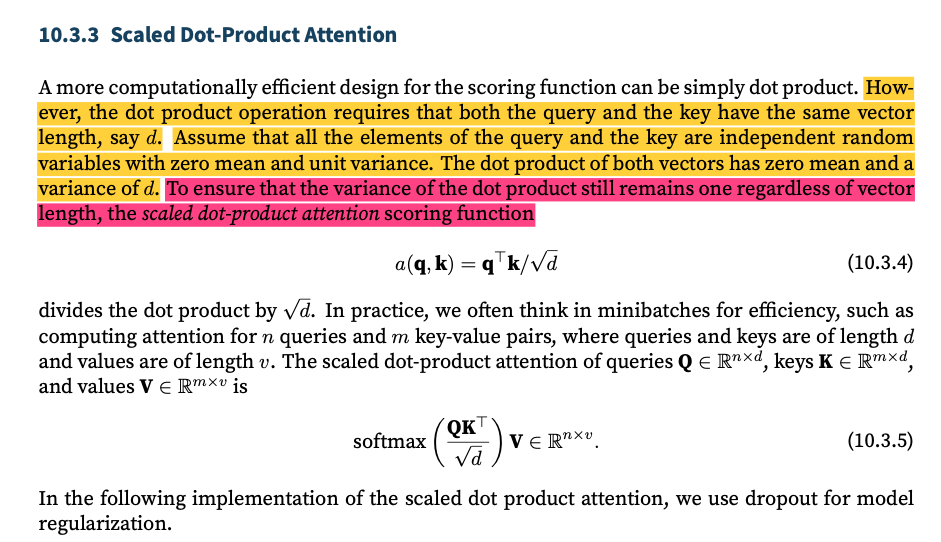

In [11]:
import math
class DotProductAttention(nn.Module):
  def __init__(self,dropout,**kwargs):
    super(DotProductAttention,self).__init__(**kwargs)
    self.dropout=nn.Dropout(dropout)
  
  def forward(self,queries,keys,values,valid_lens=None):
    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    d=queries.shape[-1]
    scores=torch.bmm(queries,keys.permute(0,2,1))/math.sqrt(d) 
    self.attention_weights = masked_softmax(scores, valid_lens) # batch_size X no_queries X no_key_values
    return torch.bmm(self.attention_weights,values) #batch_size X no_queries X value_dims


In [12]:
queries = torch.normal(0, 1, (2, 1, 2)) 
attention = DotProductAttention(dropout=0.5) 
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

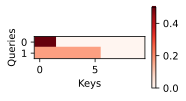

In [13]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

# Bahdanau Attention 

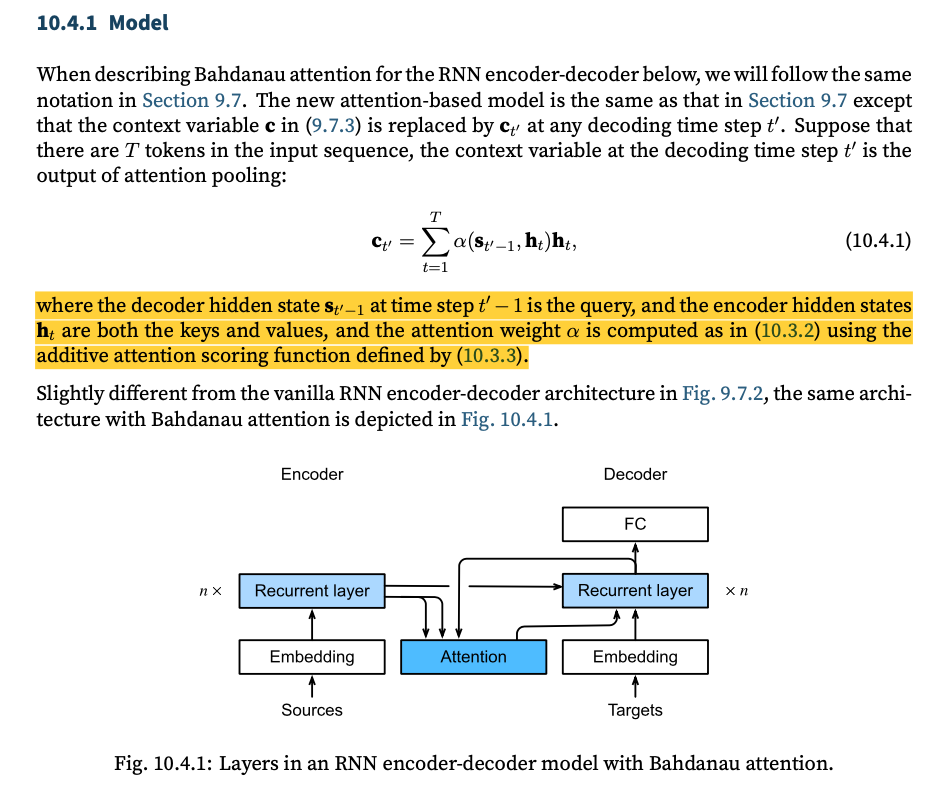

In [14]:
class Seq2SeqEncoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0, **kwargs):
    super(Seq2SeqEncoder, self).__init__(**kwargs)
    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embed_size) 
    self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,dropout=dropout)

  def forward(self,X,*args):
    X = self.embedding(X) #batch_size X num_steps X embed_size
    # In RNN models, the first axis corresponds to time steps
    X = X.permute(1, 0, 2) # num_steps X batch_size  X embed_size
    output, state = self.rnn(X) 
    #output-> num_steps X batch_size X num_hiddens
    #state-> num_layers X batch_size X num_hiddens
    return output,state

In [15]:
class Seq2SeqAttentionDecoder(nn.Module):
  def __init__(self,vocab_size, embed_size, num_hiddens, num_layers,dropout=0, **kwargs):
    super(Seq2SeqAttentionDecoder,self).__init__(**kwargs)
    #Queries->prev decoder hidden state i.e (batch_size,1,num_hiddens)
    #Keys & Values-> Encoder final layer hidden_state i.e (num_layers,num_hiddens)
    self.attention = AdditiveAttention(query_size=num_hiddens, key_size=num_hiddens, hidden_dims=num_hiddens, dropout=dropout)
    self.embedding = nn.Embedding(vocab_size, embed_size) 
    self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs, enc_valid_lens, *args):
    outputs, hidden_state = enc_outputs
    #outputs after permuting-> (batch_size,num_steps,num_hiddens) #hidden_state-> (num_layers,batch_size,num_hiddens)
    #enc_valid_lens-> (batch_size,)
    return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
  
  def forward(self,X,state):
    enc_outputs, hidden_state, enc_valid_lens = state
    X = self.embedding(X).permute(1, 0, 2) #num_steps,batch_size,embed_size
    outputs, self._attention_weights = [], []
    for x in X:
      #x is (batch_size,embed_size)
      query=hidden_state[-1][:,None,:] #(batch_size,1,num_hiddens)

      #attention_output is (batch_size,no of queries, value_dims)
      #Thus we get context->(batch_size,1,num_hiddens)
      context=self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
      x = torch.cat((context, x[:,None,:]), dim=-1) #(batch_size,1,embed_size+num_hiddens)

      out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state) #Update decoder hidden state
      outputs.append(out)

      #batch_size X no_of queries X no_of keys
      #That is batch_size X 1 X num_steps
      self._attention_weights.append(self.attention.attention_weights)
    
    # After fully-connected layer transformation, shape of `outputs`: # (`num_steps`, `batch_size`, `vocab_size`)
    outputs = self.dense(torch.cat(outputs, dim=0))
    return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,enc_valid_lens]

  @property
  def attention_weights(self):
    return self._attention_weights

#Outputs returned
''' 1) decoder outputs batch_size,num_steps,vocab_size
    2) 2.1) encoder output batch_size,num_steps,hidden_dims
       2.2) decoder hidden state of final cell, num_layers,batch_size,num_hiddens
       2.3) enc_valid_lens (batch_size,)

'''

' 1) decoder outputs batch_size,num_steps,vocab_size\n    2) 2.1) encoder output batch_size,num_steps,hidden_dims\n       2.2) decoder hidden state of final cell, num_layers,batch_size,num_hiddens\n       2.3) enc_valid_lens (batch_size,)\n\n'

In [16]:
#Encoder Decoder
class EncoderDecoder(nn.Module):
  """The base class for the encoder-decoder architecture.""" 
  def __init__(self, encoder, decoder, **kwargs):
    super(EncoderDecoder, self).__init__(**kwargs) 
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, enc_X, dec_X, *args):
    enc_outputs = self.encoder(enc_X, *args)
    dec_state = self.decoder.init_state(enc_outputs, *args) 
    return self.decoder(dec_X, dec_state)

In [17]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
  """The softmax cross-entropy loss with masks."""
  # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`) 
  # `label` shape: (`batch_size`, `num_steps`)
  # `valid_len` shape: (`batch_size`,)
  def forward(self, pred, label, valid_len):
    weights = torch.ones_like(label) #batch_size X num_steps
    weights = sequence_mask(weights, valid_len) #batch_size X num_steps
    self.reduction='none'
    #y_hat-> batch_size X vocab_size X num_steps, y-> batch_size X num_steps
    #Output-> batch_size X num_steps (since reduction=='none')
    unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label) 
    weighted_loss = (unweighted_loss * weights).mean(dim=1) #batch_size
    return weighted_loss

In [18]:
def grad_clipping(net, theta):
  """Clip the gradient."""
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad] 
  else:
    params = net.params
  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params)) 
  if norm > theta:
    for param in params: 
      param.grad[:] *= theta / norm

In [19]:
def train_seq2seq(net, data_iter,loss,optimizer, num_epochs, target_vocab, device):
  def xavier_init_weights(m):
    if type(m) == nn.Linear: 
      nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
      for param in m._flat_weights_names:
        if "weight" in param: 
          nn.init.xavier_uniform_(m._parameters[param])
  net.apply(xavier_init_weights)
  net.to(device)
  net.train()
  for epoch in range(num_epochs):
    timer = d2l.Timer()
    metric = d2l.Accumulator(2) # Sum of training loss, no of unmasked tokens
    for batch in data_iter:
      optimizer.zero_grad()
      X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
      bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],device=device).reshape(-1, 1) # batch_size X 1

      #Y-> batch_size X num_steps
      #dec_input-> batch_size X num_steps (add bos omit eos)
      dec_input = torch.cat([bos, Y[:, :-1]], 1) # Teacher forcing

      Y_hat, _ = net(X, dec_input, X_valid_len)
      l = loss(Y_hat, Y, Y_valid_len)
      #Sum along entire batch
      l.sum().backward() # Make the loss scalar for `backward`
      grad_clipping(net, 1)
      num_tokens = Y_valid_len.sum() #Note how we consider UNMASKED tokens only
      optimizer.step()
      with torch.no_grad():
        metric.add(l.sum(), num_tokens)

    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} ' f'tokens/sec on {str(device)}')

In [20]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1 
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab =d2l.load_data_nmt(batch_size, num_steps)


encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
loss=MaskedSoftmaxCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [21]:
train_seq2seq(net, train_iter, loss,optimizer,num_epochs, tgt_vocab, device)

loss 0.468, 2323.5 tokens/sec on cuda:0
loss 0.327, 2797.7 tokens/sec on cuda:0
loss 0.285, 3125.9 tokens/sec on cuda:0
loss 0.266, 3792.2 tokens/sec on cuda:0
loss 0.254, 4522.1 tokens/sec on cuda:0
loss 0.243, 4556.2 tokens/sec on cuda:0
loss 0.235, 4583.5 tokens/sec on cuda:0
loss 0.226, 4155.9 tokens/sec on cuda:0
loss 0.219, 3131.7 tokens/sec on cuda:0
loss 0.211, 5707.7 tokens/sec on cuda:0
loss 0.204, 4131.4 tokens/sec on cuda:0
loss 0.196, 3940.7 tokens/sec on cuda:0
loss 0.188, 4210.8 tokens/sec on cuda:0
loss 0.181, 4769.7 tokens/sec on cuda:0
loss 0.174, 4339.0 tokens/sec on cuda:0
loss 0.167, 3646.6 tokens/sec on cuda:0
loss 0.162, 3655.5 tokens/sec on cuda:0
loss 0.156, 3545.0 tokens/sec on cuda:0
loss 0.151, 4337.9 tokens/sec on cuda:0
loss 0.147, 4348.5 tokens/sec on cuda:0
loss 0.142, 3677.2 tokens/sec on cuda:0
loss 0.137, 5475.1 tokens/sec on cuda:0
loss 0.133, 3987.9 tokens/sec on cuda:0
loss 0.129, 4237.9 tokens/sec on cuda:0
loss 0.126, 4704.3 tokens/sec on cuda:0


In [22]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .'] 

for eng, fra in zip(engs, fras):
  translation, dec_attention_weight_seq = d2l.predict_seq2seq( net, eng, src_vocab, tgt_vocab, num_steps, device, True)
  print(f'{eng} => {translation}, ',f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


# Multi-Head Attention 

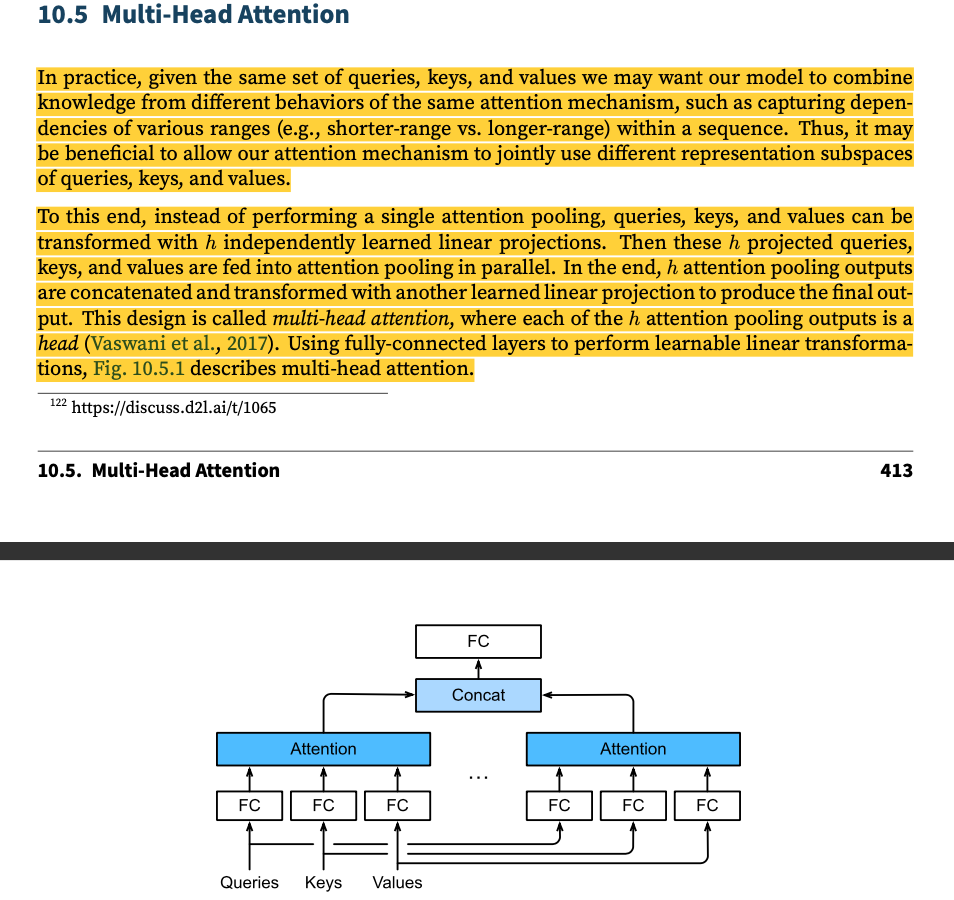

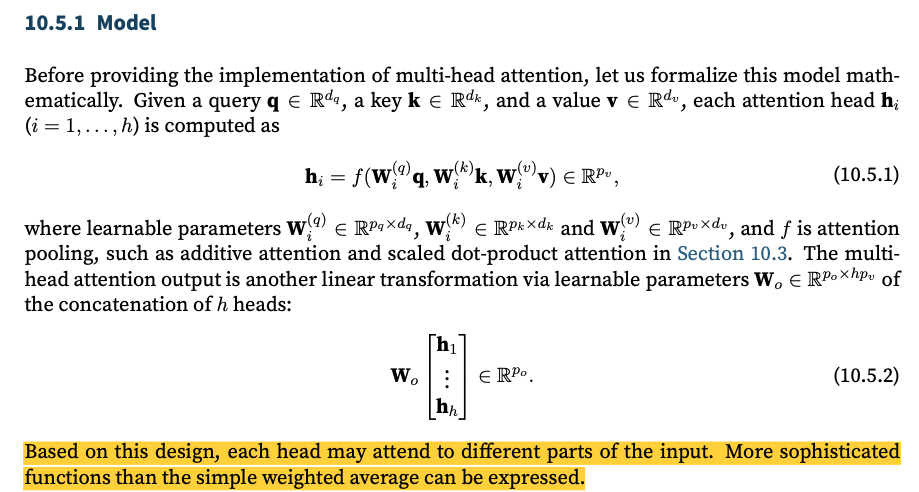

In [23]:
class MultiHeadAttention(nn.Module):
  def __init__(self, key_size, query_size, value_size, num_hiddens,num_heads, dropout, bias=False, **kwargs):
    super(MultiHeadAttention, self).__init__(**kwargs) 
    self.num_heads = num_heads
    self.attention = DotProductAttention(dropout)
    self.W_q = nn.Linear(query_size, num_hiddens, bias=bias) 
    self.W_k = nn.Linear(key_size, num_hiddens, bias=bias) 
    self.W_v = nn.Linear(value_size, num_hiddens, bias=bias) 
    self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

  def forward(self, queries, keys, values, valid_lens):
    # Shape of `queries`, `keys`, or `values`:
    # (`batch_size`, no. of queries or key-value pairs, `num_hiddens`)
    # Shape of `valid_lens`:
    # (`batch_size`,) or (`batch_size`, no. of queries)
    # After transposing, shape of output `queries`, `keys`, or `values`: 
    # (`batch_size` * `num_heads`, no. of queries or key-value pairs, `num_hiddens` / `num_heads`)
    queries = transpose_qkv(self.W_q(queries), self.num_heads)
    keys = transpose_qkv(self.W_k(keys), self.num_heads)
    values = transpose_qkv(self.W_v(values), self.num_heads)

    if valid_lens is not None:
      #We copy every valid len as many times as there are attention heads, to get (batch_size,)-> (batch_size*num_heads,)
      valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

    output = self.attention(queries, keys, values, valid_lens) #batch_size*num_heads, num_queries , num_hiddens/num_heads
    
    output_concat = transpose_output(output, self.num_heads) #batch_size,num_queries,num_hiddens
    return self.W_o(output_concat)


In [24]:
def transpose_qkv(X,num_heads):
  #X->batch_size,num_queries/keys/values,num_hiddens
  X = X.reshape(X.shape[0], X.shape[1], num_heads, -1) #batch_size,num_queries/keys/values,num_heads,num_hiddens/num_heads
  X = X.permute(0, 2, 1, 3)
  return X.reshape(-1, X.shape[2], X.shape[3]) #batch_size*num_heads, num_queries/keys/values , num_hiddens/num_heads

def transpose_output(X, num_heads):
  """Reverse the operation of `transpose_qkv`."""
  #X->batch_size*num_heads, num_queries/keys/values , num_hiddens/num_heads
  X = X.reshape(-1, num_heads, X.shape[1], X.shape[2]) # batch_size,num_heads,num_queries/keys/values,num_hiddens/num_heads
  X = X.permute(0, 2, 1, 3) # batch_size,num_queries/keys/values,num_heads,num_hiddens/num_heads
  return X.reshape(X.shape[0], X.shape[1], -1) #batch_size,num_queries/keys/values,num_heads,num_hiddens

In [25]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

# Positional Encodings

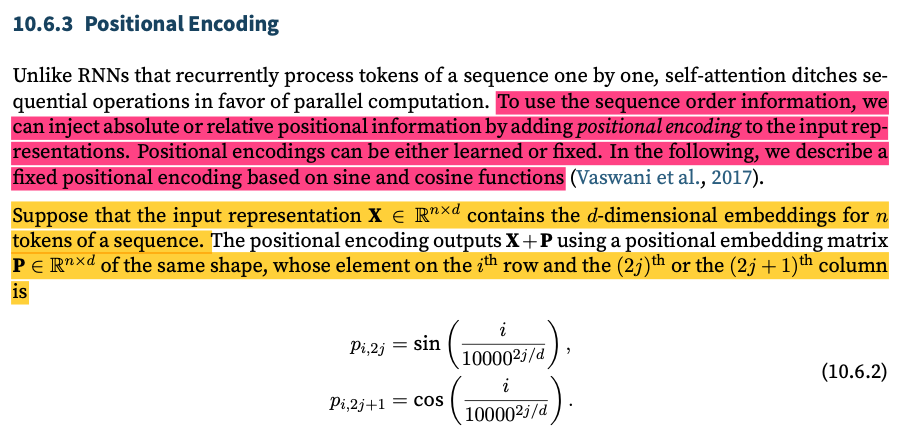

In [26]:
max_len=512
hidden_dims=768
torch.pow(10000,torch.arange(0,num_hiddens,2,dtype=torch.float)/num_hiddens).shape

torch.Size([50])

In [27]:
torch.arange(max_len, dtype=torch.float32).reshape(-1,1).shape

torch.Size([512, 1])

In [28]:
(torch.arange(max_len, dtype=torch.float32).reshape(-1,1)/torch.pow(10000,torch.arange(0,num_hiddens,2,dtype=torch.float)/num_hiddens)).shape

torch.Size([512, 50])

In [29]:
class PositionalEncoding(nn.Module):
  def __init__(self, num_hiddens, dropout, max_len=1000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(dropout)
    self.P = torch.zeros((1, max_len, num_hiddens))

    # Reshape max_len to max_len X 1, hence rows signify each position in the sequence
    #Columns of X and P must go upto num_hiddens, here starting from 0 we go upto num_hiddens skipping 2
    #X-> batch_size,num_hiddens
    X=torch.arange(max_len, dtype=torch.float32).reshape(-1,1)/ torch.pow(10000,torch.arange(0,num_hiddens,2,dtype=torch.float)/num_hiddens)
    self.P[:, :, 0::2] = torch.sin(X) 
    self.P[:, :, 1::2] = torch.cos(X)

  def forward(self, X):
    #X->batch_size,max_len,num_hiddens
    X = X + self.P[:, :X.shape[1], :].to(X.device) #Take p only upto max_len
    return self.dropout(X)


**In the positional embedding matrix P, rows correspond to positions within a sequence and columns represent different positional encoding dimensions**. In the example below, we can see that the 6th and the 7th columns of the positional embedding matrix have a higher frequency than the 8th and the 9th columns. The offset between the 6th and the 7th (same for the 8th and the 9th) columns is due to the alternation of sine and cosine functions.

torch.Size([1, 60, 32]) torch.Size([1, 60, 32])


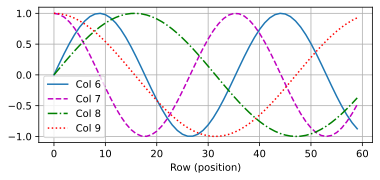

In [30]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
print(X.shape,P.shape)
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

##Absolute Positional Information

To see how the monotonically decreased frequency along the encoding dimension relates to ab- solute positional information, let us print out the binary representations of 0, 1, . . . , 7. As we can see, the lowest bit, the second-lowest bit, and the third-lowest bit alternate on every number, ev- ery two numbers, and every four numbers, respectively

In [31]:
for i in range(8):
  print(f'{i} in binary is {i:>03b}')

0 in binary is 000
1 in binary is 001
2 in binary is 010
3 in binary is 011
4 in binary is 100
5 in binary is 101
6 in binary is 110
7 in binary is 111


In binary representations, a higher bit has a lower frequency than a lower bit. **Similarly, as demonstrated in the heat map below, the positional encoding decreases frequencies along the encoding dimension by using trigonometric functions**. Since the outputs are float numbers, such continu- ous representations are more space-efficient than binary representations.

torch.Size([1, 1, 60, 32])


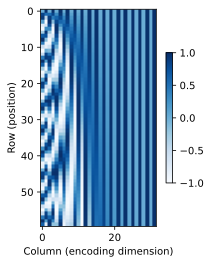

In [32]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0) 
print(P.shape)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

##Relative Positional Encodings
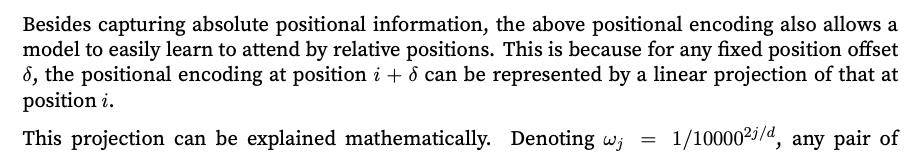

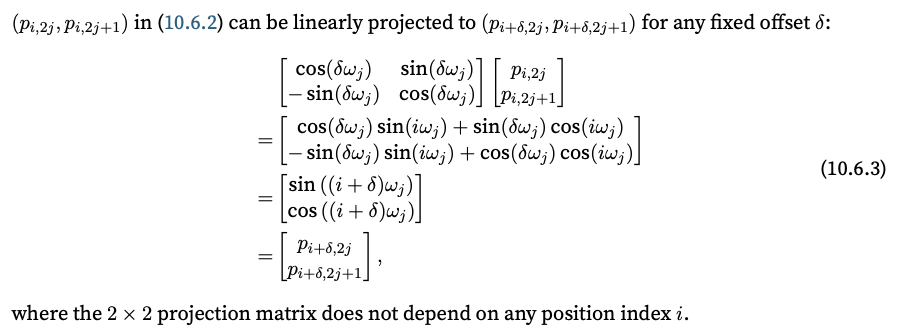

# Transformer 

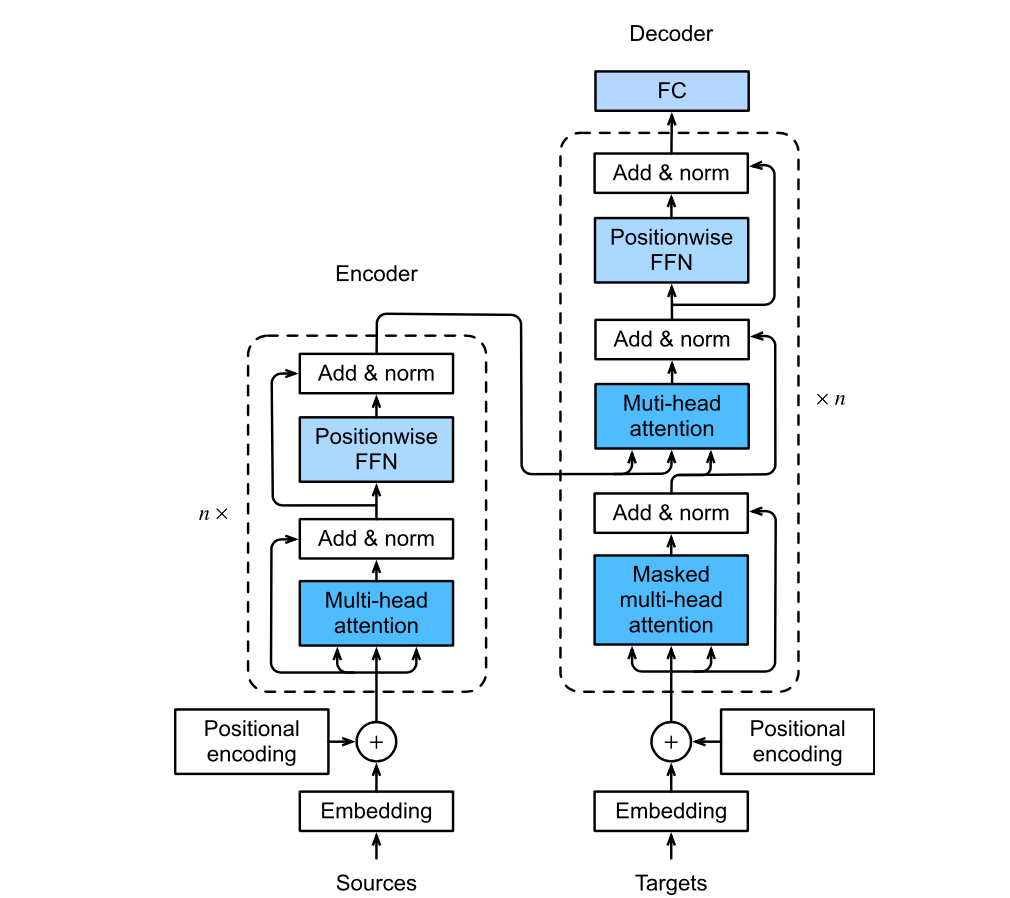

In [33]:
class PositionWiseFFN(nn.Module):
  """Positionwise feed-forward network."""
  def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,**kwargs):
    super(PositionWiseFFN, self).__init__(**kwargs) 
    self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens) 
    self.relu = nn.ReLU()
    self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

  def forward(self, X):
    return self.dense2(self.relu(self.dense1(X)))

Layer normalization is the same as batch normalization except that the former normalizes across the feature dimension. Despite its pervasive applications in computer vision, batch normalization is usually empirically less effective than layer normalization in natural language processing tasks, whose inputs are often variable-length sequences.

In [34]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
X

tensor([[1., 2.],
        [2., 3.]])

In [35]:
# Compute mean and variance from `X` in the training mode 
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [36]:
class AddNorm(nn.Module):
  """Residual connection followed by layer normalization.""" 
  def __init__(self, normalized_shape, dropout, **kwargs):
    super(AddNorm, self).__init__(**kwargs) 
    self.dropout = nn.Dropout(dropout) 
    self.ln = nn.LayerNorm(normalized_shape)

  def forward(self, X, Y):
    return self.ln(self.dropout(Y) + X)

In [37]:
class EncoderBlock(nn.Module):
  """Transformer encoder block."""
  def __init__(self, key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,dropout, use_bias=False, **kwargs): 
    super(EncoderBlock, self).__init__(**kwargs)
    #batch_size X no_queries X value_size 
    self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout,use_bias)
    #norm_shape is [seq_len,num_hiddens] 
    self.addnorm1 = AddNorm(norm_shape, dropout) 
    self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens) 
    self.addnorm2 = AddNorm(norm_shape, dropout)

  def forward(self, X, valid_lens):
    Y = self.addnorm1(X, self.attention(X, X, X, valid_lens)) 
    return self.addnorm2(Y, self.ffn(Y))

In [38]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5) 
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [39]:
class TransformerEncoder(nn.Module):
  def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens,
               norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
               dropout, use_bias=False, **kwargs):
    super(TransformerEncoder, self).__init__(**kwargs) 
    self.num_hiddens = num_hiddens
    self.embedding = nn.Embedding(vocab_size, num_hiddens) 
    self.pos_encoding = PositionalEncoding(num_hiddens, dropout) 
    self.blks = nn.Sequential()
    for i in range(num_layers): 
      self.blks.add_module("block"+str(i),EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,
                                                       ffn_num_input, ffn_num_hiddens,num_heads, dropout, use_bias))
  def forward(self,X,valid_lens,*args):
    # values are multiplied by the square root of the embedding dimension 
    # to rescale before they are summed up
    X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
    self.attention_weights = [None] * len(self.blks)
    for i, blk in enumerate(self.blks):
      X = blk(X, valid_lens) 
      self.attention_weights[i] = blk.attention.attention.attention_weights 
    return X



In [40]:
class DecoderBlock(nn.Module):
  # The `i`-th block in the decoder
  def __init__(self, key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,dropout, i, **kwargs):
      super(DecoderBlock, self).__init__(**kwargs) 
      self.i = i
      self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout) 
      self.addnorm1 = AddNorm(norm_shape, dropout)
      self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout) 
      self.addnorm2 = AddNorm(norm_shape, dropout)
      self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,num_hiddens) 
      self.addnorm3 = AddNorm(norm_shape, dropout)

  def forward(self, X, state):
    #Note that state[2] is a list of length num_layers
    enc_outputs, enc_valid_lens = state[0], state[1]
    # During training, all the tokens of any output sequence are processed # at the same time, so `state[2][self.i]` is `None` as initialized.
    # When decoding any output sequence token by token during prediction, # `state[2][self.i]` contains representations of the decoded output at 
    # the `i`-th block up to the current time step
    if state[2][self.i] is None:
      key_values = X #Decoder inputs as a batch, so for every layer the input is the out of the previous layer
    else:
      key_values = torch.cat((state[2][self.i], X), axis=1) #Concatenate new token along with old ones for prediction
    
    state[2][self.i] = key_values
    if self.training:
      batch_size, num_steps, _ = X.shape
      # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where every row is [1, 2, ..., `num_steps`]
      #This is the causal mask, 
      dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1) 
    else:
      dec_valid_lens = None
    
    # Self-attention
    X2 = self.attention1(X, key_values, key_values, dec_valid_lens)  #decoder valid lens are (batch_size,num_steps)
    Y = self.addnorm1(X, X2)
    # Encoder-decoder attention. Shape of `enc_outputs`:
    # (`batch_size`, `num_steps`, `num_hiddens`)
    Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens) #encoder valid lens are (batch_size,)
    Z = self.addnorm2(Y, Y2)
    return self.addnorm3(Z, self.ffn(Z)), state
    #The first returnable is the decoder output, batch_size X num_steps X num_hiddens
    #The second returnable is a list that contains
    # 1) enc_outputs 2) encoder_valid_lens 3) a list where position i contains input to the ith decoder layer

In [45]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0) 
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
print(state[0].shape,state[1].shape)
dec_outputs=decoder_blk(X, state)

torch.Size([2, 100, 24]) torch.Size([2])


In [48]:
dec_outputs[0].shape,len(dec_outputs[1])

(torch.Size([2, 100, 24]), 3)

In [49]:
dec_outputs[1][0].shape,dec_outputs[1][1].shape,len(dec_outputs[1][2]) #1 since we only have 1 block for now

(torch.Size([2, 100, 24]), torch.Size([2]), 1)

In [50]:
dec_outputs[1][2][0].shape

torch.Size([2, 100, 24])

In [51]:
class TransformerDecoder(d2l.AttentionDecoder):
  def __init__(self, vocab_size, key_size, query_size, value_size,num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
    num_heads, num_layers, dropout, **kwargs):
    super(TransformerDecoder, self).__init__(**kwargs) 
    self.num_hiddens = num_hiddens
    self.num_layers = num_layers
    self.embedding = nn.Embedding(vocab_size, num_hiddens) 
    self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout) 
    self.blks = nn.Sequential()
    for i in range(num_layers):
      self.blks.add_module("block"+str(i),DecoderBlock(key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens,num_heads, dropout, i)) 
      self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs, enc_valid_lens, *args):
    return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

  def forward(self, X, state):
    X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens)) 
    self._attention_weights = [[None] * len(self.blks) for _ in range (2)] #2 since we have 2 MultiHead Attention Layers in each decoder block

    for i, blk in enumerate(self.blks):
      X, state = blk(X, state)
    # Decoder self-attention weights 
    self._attention_weights[0][i] = blk.attention1.attention.attention_weights 
    # Encoder-decoder attention weights 
    self._attention_weights[1][i] = blk.attention2.attention.attention_weights 
    return self.dense(X), state
    
  @property
  def attention_weights(self):
    return self._attention_weights

In [53]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10 
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32] #Only embedding_dims i.e num_hiddens
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = TransformerEncoder(
len(src_vocab), key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout)

decoder = TransformerDecoder(
len(tgt_vocab), key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout)

net = EncoderDecoder(encoder, decoder)
loss=MaskedSoftmaxCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [54]:
train_seq2seq(net, train_iter, loss,optimizer,num_epochs, tgt_vocab, device)

loss 0.433, 6640.8 tokens/sec on cuda:0
loss 0.315, 4647.5 tokens/sec on cuda:0
loss 0.271, 6522.6 tokens/sec on cuda:0
loss 0.246, 6283.6 tokens/sec on cuda:0
loss 0.226, 6549.6 tokens/sec on cuda:0
loss 0.213, 6403.8 tokens/sec on cuda:0
loss 0.200, 5944.1 tokens/sec on cuda:0
loss 0.192, 6408.7 tokens/sec on cuda:0
loss 0.183, 6431.8 tokens/sec on cuda:0
loss 0.173, 6354.0 tokens/sec on cuda:0
loss 0.167, 6252.5 tokens/sec on cuda:0
loss 0.157, 6357.5 tokens/sec on cuda:0
loss 0.152, 6874.6 tokens/sec on cuda:0
loss 0.143, 6935.1 tokens/sec on cuda:0
loss 0.141, 6802.1 tokens/sec on cuda:0
loss 0.136, 6320.0 tokens/sec on cuda:0
loss 0.130, 3529.2 tokens/sec on cuda:0
loss 0.127, 6447.5 tokens/sec on cuda:0
loss 0.116, 6611.8 tokens/sec on cuda:0
loss 0.114, 6810.0 tokens/sec on cuda:0
loss 0.110, 6485.1 tokens/sec on cuda:0
loss 0.107, 6703.0 tokens/sec on cuda:0
loss 0.106, 6822.1 tokens/sec on cuda:0
loss 0.101, 6642.5 tokens/sec on cuda:0
loss 0.097, 6548.1 tokens/sec on cuda:0


In [55]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .'] 
for eng, fra in zip(engs, fras):
  translation, dec_attention_weight_seq = d2l.predict_seq2seq( net, eng, src_vocab, tgt_vocab, num_steps, device, True)
  print(f'{eng} => {translation}, ',f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


# Visualizing Attention 

##Encoder Attention

In [58]:
len(net.encoder.attention_weights),net.encoder.attention_weights[0].shape

(2, torch.Size([4, 10, 10]))

In [59]:
torch.cat(net.encoder.attention_weights, 0).shape

torch.Size([8, 10, 10])

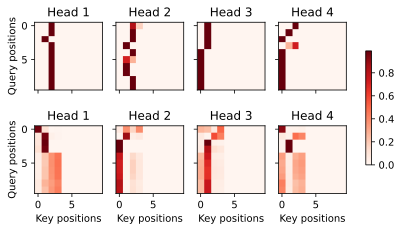

In [60]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,-1, num_steps))

d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',ylabel='Query positions', titles=['Head %d' % i for i in range(1, num_heads+1)], figsize=(7, 3.5))